In [1]:

# required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

%matplotlib inline

#### **Data Overview:**

In [2]:
df = pd.read_parquet("../features/training_set")
df = df.sample(frac=1.0, random_state=47).reset_index(drop=True)

In [3]:
df.shape

(103663, 16)

In [4]:
df.head()

,race_year,race_name,driver_id,driver_nationality,team,lap_percent,position_gain,pit_stop_rate,rolling_avg_lap_time_3,lap_time_cv_3,qualifying_avg_sec,qualifying_delta,points,rolling_fatigue_score,position_change_rate_3,is_pole_position
0,2020,Styrian Grand Prix,830,Dutch,Red Bull,0.239437,0,8.352938,68.859998,0.000367,78.907997,2.550995,15.0,-6.267836,0,True
1,2020,Portuguese Grand Prix,817,Australian,Renault,0.569231,3,1.756756,83.161001,0.012472,77.550999,0.139999,2.0,-1.577974,1,False
2,2018,Mexican Grand Prix,20,German,Ferrari,0.971831,2,2.057971,80.057999,0.001082,75.591332,1.119003,18.0,-3.564775,0,True
3,2018,United States Grand Prix,843,New Zealander,Toro Rosso,0.327273,9,3.055555,102.529335,0.001676,95.205992,0.000000,2.0,-3.754922,0,False
4,2013,Chinese Grand Prix,8,Finnish,Lotus F1,0.964286,0,3.111111,100.174665,0.001467,95.821998,2.285004,18.0,-3.485187,1,True


* Drop `points` because it might dominates the model's decisions, and may cause it to rely on driver history rather than real-time race dynamics, which reduces generalizability and hides the true predictive power of the live telemetry features.

In [5]:
df = df.drop(columns=['race_year', 'race_name', 'driver_id', 'driver_nationality', 'team', 'points'], axis=1)

In [6]:
# null counts
df.isnull().sum()

lap_percent                 0
position_gain               0
pit_stop_rate               0
rolling_avg_lap_time_3      0
lap_time_cv_3               0
qualifying_avg_sec          0
qualifying_delta          511
rolling_fatigue_score       0
position_change_rate_3      0
is_pole_position            0
dtype: int64

In [7]:
# 95th percentile of qualifying_delta (excluding nulls)
qdelta_95 = np.nanpercentile(df['qualifying_delta'], 95)
qdelta_95

np.float32(10.782005)

In [8]:
df['qualifying_delta'] = df['qualifying_delta'].fillna(qdelta_95)

In [9]:
# change the dtype of target from bool to int
df['is_pole_position'] = df['is_pole_position'].astype(int)

#### **Train-Test Split:**

In [10]:
# select features to scale and features to keep as it is
features_to_scale = [
    'pit_stop_rate',
    'rolling_avg_lap_time_3',
    'lap_time_cv_3',
    'qualifying_avg_sec',
    'qualifying_delta',
    'rolling_fatigue_score'
]

features_to_keep = [
    'lap_percent',
    'position_gain', 
    'position_change_rate_3'
]

In [11]:
X = df[features_to_scale + features_to_keep]
y = df['is_pole_position']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=47
)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69454, 9), (34209, 9), (69454,), (34209,))

In [14]:
y_train.value_counts(normalize=True) * 100

is_pole_position
0    66.515967
1    33.484033
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True) * 100

is_pole_position
0    66.517583
1    33.482417
Name: proportion, dtype: float64

In [16]:

# Combine and compare if rows match
train_rows = pd.DataFrame(X_train).astype(str).apply(lambda x: ''.join(x), axis=1)
test_rows = pd.DataFrame(X_test).astype(str).apply(lambda x: ''.join(x), axis=1)

# How many overlap?
overlap = train_rows.isin(test_rows).sum()
print(f"Overlapping rows: {overlap}")

Overlapping rows: 0


#### **SMOTE**

In [17]:
# Apply SMOTE on train set
smote = SMOTE(random_state=47)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [18]:
print(f"✅ After SMOTE: {X_train_smote.shape}, {y_train_smote.shape}")

✅ After SMOTE: (92396, 9), (92396,)


In [19]:
y_train_smote.value_counts(normalize=True) * 100

is_pole_position
1    50.0
0    50.0
Name: proportion, dtype: float64

#### **ML Pipeline:**

In [20]:
# ml pipeline
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), features_to_scale),
    ('keep', 'passthrough', features_to_keep)
])

# SVM with RBF (Gaussian) kernel
svm_model = SVC(
    kernel='rbf',          # Gaussian kernel
    C=1.0,                 # Regularization parameter (can be tuned)
    gamma='scale',         # Kernel coefficient (can be 'scale', 'auto', or a float)
    probability=True       # Needed if you're going to use `predict_proba` or AUC
)

In [21]:
# initializing the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

In [22]:
pipeline.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['pit_stop_rate',
                                                   'rolling_avg_lap_time_3',
                                                   'lap_time_cv_3',
                                                   'qualifying_avg_sec',
                                                   'qualifying_delta',
                                                   'rolling_fatigue_score']),
                                                 ('keep', 'passthrough',
                                                  ['lap_percent',
                                                   'position_gain',
                                                   'position_change_rate_3'])])),
                ('classifier', SVC(probability=True))])

#### **Performance Metrices:**

In [23]:
train_score = pipeline.score(X_train_smote, y_train_smote)
train_score

0.7334191956361747

In [24]:
test_score = pipeline.score(X_test, y_test)
test_score

0.7036160074834108

In [25]:
y_train_pred = pipeline.predict(X_train_smote)
y_test_pred = pipeline.predict(X_test)

In [26]:
print("Classification Report Train Set:\n", classification_report(y_train_smote, y_train_pred))

Classification Report Train Set:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72     46198
           1       0.72      0.77      0.74     46198

    accuracy                           0.73     92396
   macro avg       0.74      0.73      0.73     92396
weighted avg       0.74      0.73      0.73     92396



In [27]:
print("Classification Report Test Set:\n", classification_report(y_test, y_test_pred))

Classification Report Test Set:
               precision    recall  f1-score   support

           0       0.84      0.69      0.75     22755
           1       0.54      0.74      0.62     11454

    accuracy                           0.70     34209
   macro avg       0.69      0.71      0.69     34209
weighted avg       0.74      0.70      0.71     34209



In [28]:


def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC-AUC curve for a given model and test set.
    
    Args:
        model: Trained model (must have predict_proba method).
        X_test: Features of test set.
        y_test: True labels of test set.
    """
    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError("Model does not support probability prediction.")

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Plot
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

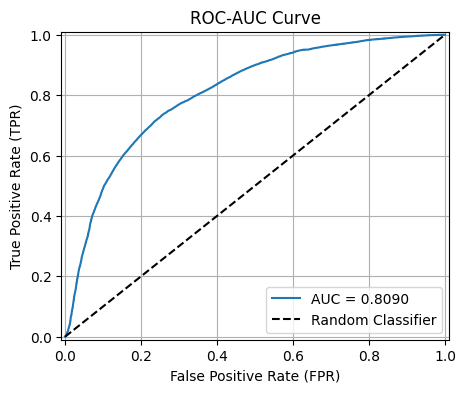

In [29]:
plot_roc_curve(pipeline, X_train_smote, y_train_smote)

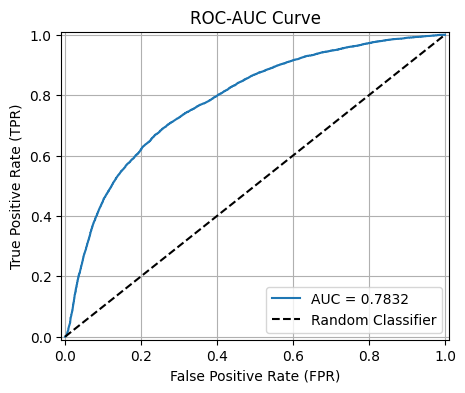

In [30]:
plot_roc_curve(pipeline, X_test, y_test)

#### **Hyper parameters Tuning:**

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import optuna

In [33]:
X_train.columns

Index(['pit_stop_rate', 'rolling_avg_lap_time_3', 'lap_time_cv_3',
       'qualifying_avg_sec', 'qualifying_delta', 'rolling_fatigue_score',
       'lap_percent', 'position_gain', 'position_change_rate_3'],
      dtype='object')